# Advance Streaming

You can do 2 things
* you can apply the aggregations over a time window
* you can trigger actions based on events (State Processing)

**the first one** is easier, and uses the `from pyspark.sql.window import Window`, here we will study its properties and types <br>
**the second one**, requires to track states, this bring OOP to the table and is not as easy as Aggregation Over Windows

## Windows Aggregation

There are 3, we will study the first 2
* Fixed Window: no data overlaping
* Slading Window: data overlaping
* Monitoring Windows: Random windows over the spectrum for analyzing behaivour

### Fixed Window Aggregation over an Event Time
|Image|Description|
|---|---|
|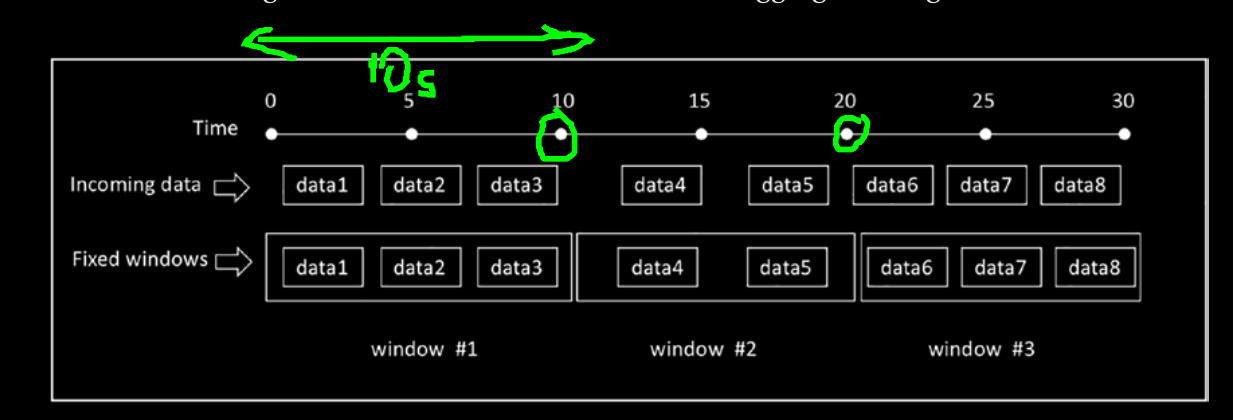|A fixed window (a.k.a. a tumbling window) operation discretizes a stream of incoming data into nonoverlapping buckets based on window length. Each piece of incoming data is placed into one of the buckets based on its event time. |

In [1]:
from pyspark.sql import SparkSession
import os
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql.window import Window

spark = SparkSession.builder.appName("SQL").getOrCreate()

24/07/05 15:33:40 WARN Utils: Your hostname, msi-MAG resolves to a loopback address: 127.0.1.1; using 192.168.0.129 instead (on interface wlp3s0)
24/07/05 15:33:40 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/05 15:33:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
schema = "`id` String, `action` String, `ts` Timestamp"

StartStreaming

In [3]:
mobile_events = spark.readStream.schema(schema).json("./input/")

Define Streaming Action - > Fixed Window Agg

In [4]:
windCountDF = mobile_events.groupBy(F.window(F.col("ts"),"10 minutes"), F.col("action")).count()

Output (Terminal)

In [6]:
mobileConsoleSQ = windCountDF.writeStream.format("console")\
                    .option("truncate", "false")\
                    .outputMode("complete")\
                    .start()

24/07/05 16:18:23 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-d6e97ddd-a827-4c13-8f26-d6a7858954bf. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
24/07/05 16:18:23 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


-------------------------------------------
Batch: 0
-------------------------------------------
+------------------------------------------+------+-----+
|window                                    |action|count|
+------------------------------------------+------+-----+
|{2018-03-02 10:10:00, 2018-03-02 10:20:00}|open  |2    |
|{2018-03-02 10:00:00, 2018-03-02 10:10:00}|close |6    |
|{2018-03-02 10:00:00, 2018-03-02 10:10:00}|open  |8    |
+------------------------------------------+------+-----+



Stop Output

In [8]:
# stop the streaming query
mobileConsoleSQ.stop()

### Sliding Window Aggregation over Event Time
|||
|---|---|
|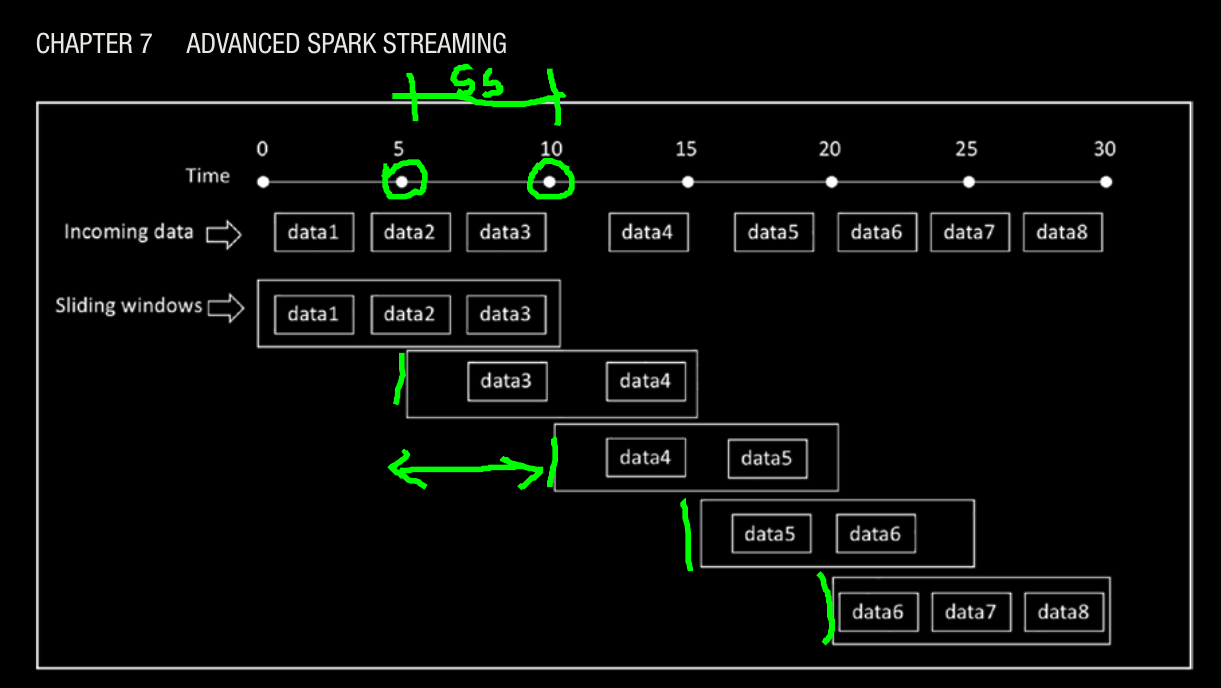|Defining a sliding window requires two pieces of information, the window length and a sliding interval, which is usually smaller than the window length|

Imagine each computer rack emits its temperature at a certain interval. You want to generate a report
about the average temperature among all computer racks and per rack over a window
length of 10 minutes and a sliding interval of 5 minutes

In [9]:
schema = "`rack` String, `temperature` Float, `ts` Timestamp"

Create StreamDataFrame

In [10]:
rack_temperature = spark.readStream.schema(schema).json("./temperatureRacks/")

In [11]:
#check whether is a Streaming DF
rack_temperature.isStreaming

True

CreateAction
> Look at the second parameter in the window, the step, is lesser than the window size

In [12]:
# group by a sliding window and perform average on the temperature column
iotAvgDF = rack_temperature.groupBy(F.window(F.col("ts"), "10 minutes", "5 minutes")).agg(F.avg("temperature").alias("avg_temp"))

> write data into the <mark>MEMORY</mark>

In [13]:
# write the data out to memory sink with query name as iot
iotMemorySQ = iotAvgDF.writeStream.format("memory")\
                        .queryName("iot")\
                        .outputMode("complete")\
                        .start()

24/07/05 16:43:00 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-6347d694-98eb-40bf-83f2-8a7c84551b1f. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
24/07/05 16:43:00 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


Look at the `queryName("iot")`

In [15]:
# now you can query the data
# window > start
spark.sql("select * from iot").orderBy("window.start").show(truncate=False)

+------------------------------------------+--------+
|window                                    |avg_temp|
+------------------------------------------+--------+
|{2017-06-02 07:55:00, 2017-06-02 08:05:00}|99.5    |
|{2017-06-02 08:00:00, 2017-06-02 08:10:00}|101.25  |
|{2017-06-02 08:05:00, 2017-06-02 08:15:00}|102.75  |
|{2017-06-02 08:10:00, 2017-06-02 08:20:00}|103.75  |
|{2017-06-02 08:15:00, 2017-06-02 08:25:00}|105.0   |
+------------------------------------------+--------+



In [16]:
iotMemorySQ.stop()

> **Add another column**

In [17]:
iotAvgByRackDF = rack_temperature.groupBy(F.window("ts", "10 minutes", "5 minutes"),"rack").agg(F.avg("temperature").alias("avg_temp"))

In [18]:
iotByRackConsoleSQ = iotAvgByRackDF.writeStream\
                    .format("memory")\
                    .queryName("iot_rack")\
                    .outputMode("complete")\
                    .start()

24/07/05 16:50:11 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-efd5e4d7-8071-4493-a0ec-e81c2aeee57e. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
24/07/05 16:50:11 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


In [19]:
spark.sql("SELECT * FROM iot_rack").orderBy("window.start").show(truncate=False)

+------------------------------------------+-----+--------+
|window                                    |rack |avg_temp|
+------------------------------------------+-----+--------+
|{2017-06-02 07:55:00, 2017-06-02 08:05:00}|rack1|99.5    |
|{2017-06-02 07:55:00, 2017-06-02 08:05:00}|rack2|99.5    |
|{2017-06-02 08:00:00, 2017-06-02 08:10:00}|rack1|100.0   |
|{2017-06-02 08:00:00, 2017-06-02 08:10:00}|rack2|102.5   |
|{2017-06-02 08:05:00, 2017-06-02 08:15:00}|rack2|104.75  |
|{2017-06-02 08:05:00, 2017-06-02 08:15:00}|rack1|100.75  |
|{2017-06-02 08:10:00, 2017-06-02 08:20:00}|rack2|106.0   |
|{2017-06-02 08:10:00, 2017-06-02 08:20:00}|rack1|101.5   |
|{2017-06-02 08:15:00, 2017-06-02 08:25:00}|rack1|102.0   |
|{2017-06-02 08:15:00, 2017-06-02 08:25:00}|rack2|108.0   |
+------------------------------------------+-----+--------+



In [20]:
# stop query stream
iotByRackConsoleSQ.stop()

# Watermarking: 
|Image|Concept|
|----------------------------------|----------------------------------|
|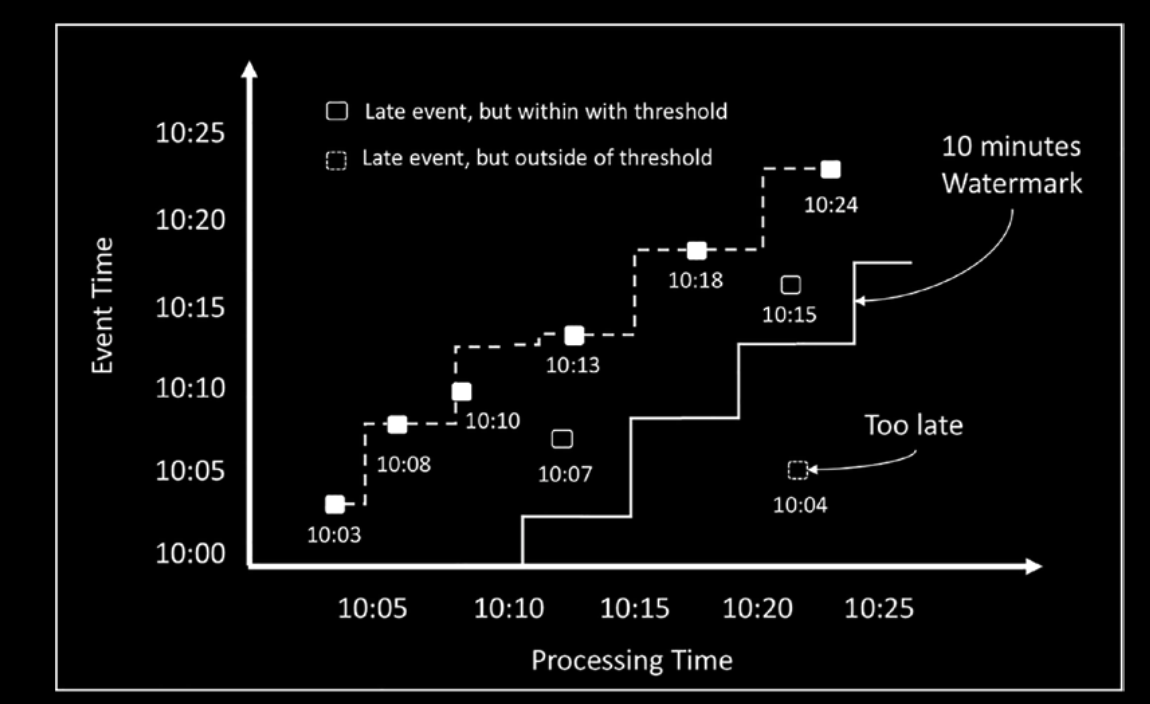|Watermarking can be seens as *tolerance*: if data arrives late, but it does inside a **10 min** delta... is tolerated, hence, aggregations will be recomputed for the interval, **it also sets the rule that after 10 min**, no data will be updated, which means under hood: <mark>this part of the dataset has become static</mark> |

> You just need to provide two pieces of data to the withWatermark
API, the event time column, and the threshold, which can be in seconds, minutes, or
hours. 

Lets create an example 

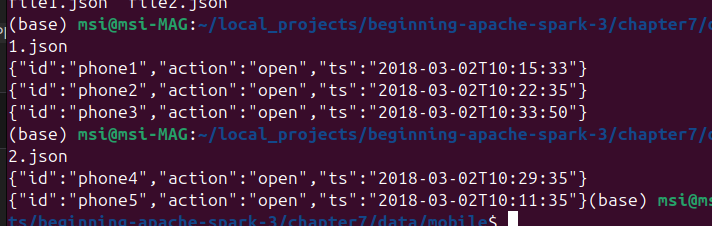

> create a new folder called `mobileStreaming`, to simulate streaming, first copy `file1.json` then `file2.json`

#### Analysis
windows os every 10 min will be generated, means 
* 10:10
* 10:20
* 10:30
This will set the max date from file1.json, `T10:33:50`, to lead the 10 min tolerance, setting the break point at `T10:23:50`

> when copying `file2.json` both values will be out of sync 
* 10:29:35 will arrive inside the 10 min window
* 10:11:35 is out of the break point 

In [22]:
mobileSchema = "`id` String, `action` String, `ts` Timestamp"

In [24]:
mobileSSDF = spark.readStream.schema(mobileSchema).json("watermarking/")

Action + WaterMark

In [25]:
# setup a streaming DataFrame with a watermark and group by ts and action column.
windowCountDF = mobileSSDF.withWatermark("ts", "10 minutes")\
                .groupBy(F.window("ts","10 minutes"), "action").count()

Print OUt in Console

In [26]:
mobileMemorySQ = windowCountDF.writeStream.format("console").option("truncate", "false")\
                .outputMode("update").start()

'''
*The output mode can’t be the complete mode and must be in either
update or append mode

*The event time column specified in the Watermark API and the
groupBy transformation must be the same one.

* When setting up a streaming DataFrame, the Watermark API must be
called before the groupBy transformation; otherwise, it is ignored.
'''

24/07/05 17:22:07 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-a1b93278-35db-49f6-8c16-136a90218cfe. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
24/07/05 17:22:07 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


'\n*The output mode can’t be the complete mode and must be in either\nupdate or append mode\n\n*The event time column specified in the Watermark API and the\ngroupBy transformation must be the same one.\n\n* When setting up a streaming DataFrame, the Watermark API must be\ncalled before the groupBy transformation; otherwise, it is ignored.\n'

-------------------------------------------
Batch: 0
-------------------------------------------
+------------------------------------------+------+-----+
|window                                    |action|count|
+------------------------------------------+------+-----+
|{2018-03-02 10:10:00, 2018-03-02 10:20:00}|open  |1    |
|{2018-03-02 10:20:00, 2018-03-02 10:30:00}|open  |1    |
|{2018-03-02 10:30:00, 2018-03-02 10:40:00}|open  |1    |
+------------------------------------------+------+-----+

-------------------------------------------
Batch: 1
-------------------------------------------
+------+------+-----+
|window|action|count|
+------+------+-----+
+------+------+-----+

-------------------------------------------
Batch: 2
-------------------------------------------
+------------------------------------------+------+-----+
|window                                    |action|count|
+------------------------------------------+------+-----+
|{2018-03-02 10:20:00, 2018-03-02 10:30

In [28]:
mobileMemorySQ.stop()

# State Processing
|Stateful Processing||
|---|---|
|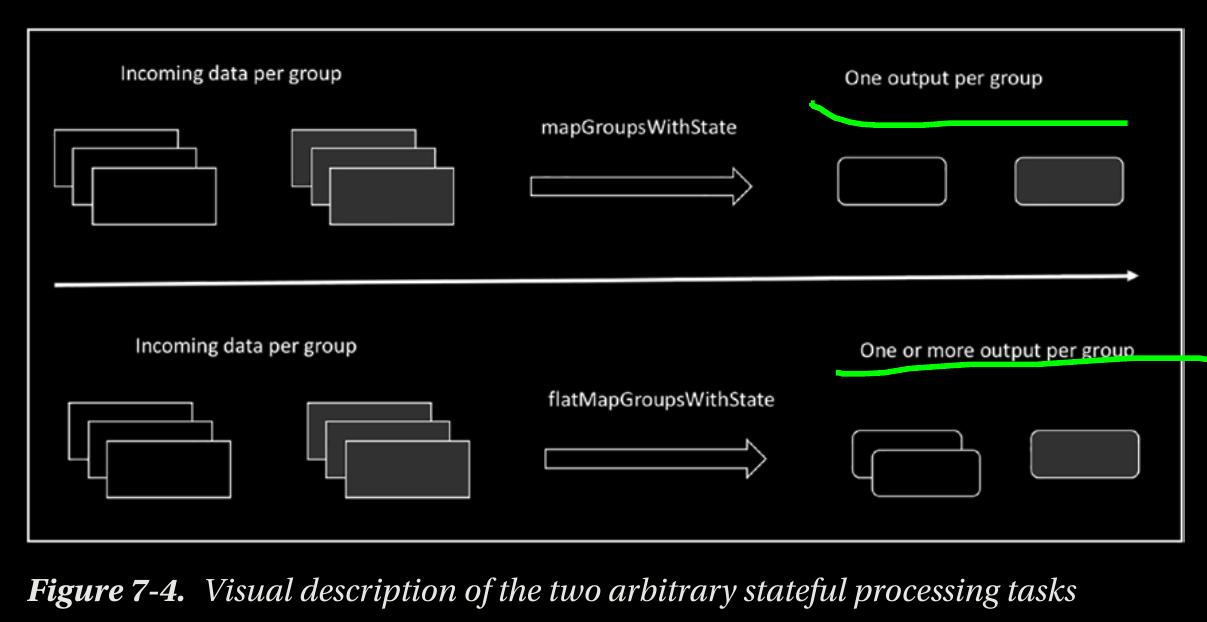|The big difference is the **callback**, whenever new data is receive the system call this function, so if you provide an instance of a class, you will be able to trace states. Talking about callbacks there are 2 types:<br> * **mapGroupsWithState**<br> * **flatMapGroupsWithState**|

### The sequence.

1) first specify the grouping by calling the groupByKey transformation and provide a group by column &#8594; **output**  `KeyValueGroupedDataset` class.
2) Select either `mapGroupsWithState` or `flatMapGroupsWithState` function.
    * `mapGroupsWithState`(timeout type, a user-defined callback function)
        * Supports only the *update output mode*
    * `flatMapGroupsWithState`(output mode, timeout type, a user-defined callback function)
        * Supports both append and update modes

> The following is the contract between Structured Streaming and the user-defined callback function.
> * The user-defined callback function is invoked once for each group in each trigger. 
> *  Each time the user-defined callback function is called, the following information is passed along.
>       * The value of the group key
>       * All the data of a group (order not guaranteed)
>       * The previous state of a group, which was returned by previous invocation of the same group. (so you have to return it)


## Extracting Patterns with `mapGroupsWithState`
> The pattern of interest is the three consecutive temperature readings of 100 degrees or more from the same rack
> When such a pattern is detected,
the status of that rack is upgraded to a warning status. If the next incoming temperature
reading falls below the 100-degree threshold, the rack status is downgraded to normal.
* file1.json show the temperature over time of rack1
* file2.json show the temperature over time of rack2
* file3.json show the temperature over time of rack3


In [1]:
from pyspark.sql import SparkSession
import os
import pyspark.sql.functions as F
import pyspark.sql.types as T
# from pyspark.sql.window import Window

spark = SparkSession.builder.appName("SQL").getOrCreate()

24/07/07 14:44:11 WARN Utils: Your hostname, msi-MAG resolves to a loopback address: 127.0.1.1; using 192.168.0.129 instead (on interface wlp3s0)
24/07/07 14:44:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/07 14:44:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
cat 

In [29]:
spark.stop()